In [2]:
import pandas as pd
import numpy as np
pasc_df=pd.read_csv("pasc_df_2026.csv")#,index=False)

npz_file_path = "three_cohorts2026.npz"
with np.load(npz_file_path,allow_pickle=True) as data:
    # Access the arrays by their names
    protected_ids = data['arr1']
    responder_ids = data['arr2']
    refractory_ids = data['arr3']

In [1]:
np.unique(pasc_df['index'])
pasc_df.head()

NameError: name 'np' is not defined

In [36]:
# np.unique(pasc_df['name'])
# pasc_df['name']
import pandas as pd
import pandas as pd
import numpy as np

# df_sorted = pasc_df[pasc_df['id'].isin(protected_ids)].sort_values(by=['id', 'date'], ascending=[True, True])
# df_sorted = pasc_df[pasc_df['id'].isin(responder_ids)].sort_values(by=['id', 'date'], ascending=[True, True])
df_sorted = pasc_df[pasc_df['id'].isin(refractory_ids)].sort_values(by=['id', 'date'], ascending=[True, True])

# 2. Group by ID and take the first row (the earliest occurrence)
earliest_pasc = df_sorted.groupby('id').first().reset_index()

# 3. Now compute statistics on the 'prior_vax_count' column of these earliest records
vax_stats_at_start = earliest_pasc['prior_vax_count'].value_counts(dropna=False).sort_index()

# 4. Calculate Mean/Median of doses at initial PASC
mean_doses_at_start = earliest_pasc['prior_vax_count'].mean()
median_doses_at_start = earliest_pasc['prior_vax_count'].median()

# Display results
print("Vaccine Dose Distribution at Initial PASC Score:")
print(vax_stats_at_start)
print(f"\nAverage doses at first PASC: {mean_doses_at_start:.2f}")


Vaccine Dose Distribution at Initial PASC Score:
prior_vax_count
0      7
1     39
2    154
3    355
4    110
Name: count, dtype: int64

Average doses at first PASC: 2.78


In [17]:
import pandas as pd

def build_group_plot_df(pasc_df, ids, group_name):
    df_sorted = pasc_df[pasc_df["id"].isin(ids)].sort_values(["id", "date"])
    earliest = df_sorted.groupby("id", as_index=False).first()

    s = earliest["prior_vax_count"].value_counts(dropna=False).sort_index()

    out = s.rename_axis("prior_vax_count").reset_index(name="count")
    out["group_name"] = group_name
    return out

plot_df = pd.concat([
    build_group_plot_df(pasc_df, protected_ids,  "Protected"),
    build_group_plot_df(pasc_df, responder_ids,  "Responder"),
    build_group_plot_df(pasc_df, refractory_ids, "Refractory"),
], ignore_index=True)

# optional: ensure consistent y-axis categories across groups (fill missing dose bins with 0)
all_doses = sorted(plot_df["prior_vax_count"].dropna().unique())
all_groups = plot_df["group_name"].unique()

idx = pd.MultiIndex.from_product([all_doses, all_groups], names=["prior_vax_count", "group_name"])
plot_df = (
    plot_df.set_index(["prior_vax_count", "group_name"])
           .reindex(idx, fill_value=0)
           .reset_index()
)
# sns.barplot(data=plot_df, y="prior_vax_count", x="count", hue="group_name", orient="h")


In [19]:
print("hello")
plot_df

hello


,prior_vax_count,group_name,count
0,0,Protected,993
1,0,Responder,32
2,0,Refractory,7
3,1,Protected,340
4,1,Responder,151
5,1,Refractory,39
6,2,Protected,1421
7,2,Responder,697
8,2,Refractory,154
9,3,Protected,3988


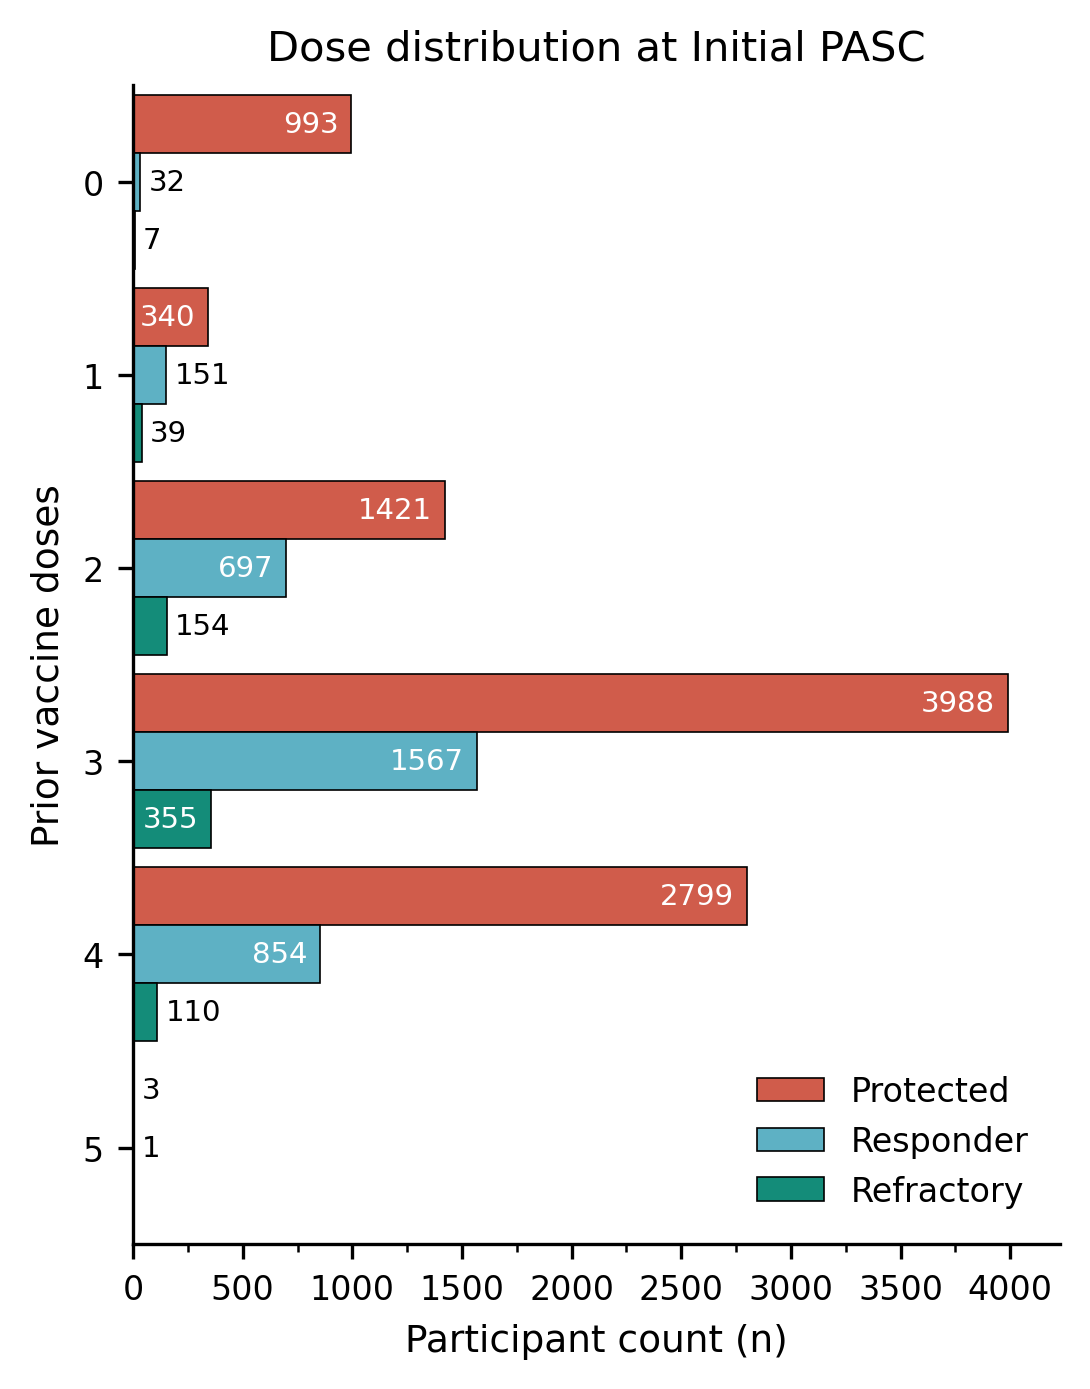

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

# --- Nature-ish defaults (compact, consistent) ---
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "axes.linewidth": 0.8
})

colors = ['#E64B35FF', '#4DBBD5FF', '#00A087FF']  # your NPG palette

# 1) Make the figure less tall (main fix for “too sparse”)
fig, ax = plt.subplots(figsize=(3.6, 4.6), dpi=300)

sns.barplot(
    data=plot_df,
    y="prior_vax_count",
    x="count",
    hue="group_name",
    palette=colors,
    orient="h",
    dodge=True,
    width=0.90,          # thicker bars
    edgecolor="black",
    linewidth=0.4,       # lighter outline than 0.6
    ax=ax
)

# 2) Titles/labels: Nature tends to keep these modest (often no title; caption does the work)
ax.set_title("Dose distribution at Initial PASC", fontsize=10, pad=6)
ax.set_xlabel("Participant count (n)", fontsize=9)
ax.set_ylabel("Prior vaccine doses", fontsize=9)

# 3) Ticks: outward, with minor ticks; no grid
ax.tick_params(direction="out", length=3.5, width=0.8, labelsize=8)
ax.xaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.tick_params(axis="x", which="minor", direction="out", length=2, width=0.6)

# 4) Limits: give only a *little* extra room for labels
max_val = plot_df["count"].max()
ax.set_xlim(0, max_val * 1.06)

# 5) Legend: inside the plot area (bottom-right is fine here)
leg = ax.legend(title=None, frameon=False, fontsize=8, loc="lower right",
                bbox_to_anchor=(0.98, 0.02), borderaxespad=0.0)

# 6) Data labels: inside for large bars, outside for small bars (reduces clutter near x~0)
threshold = max_val * 0.08  # tune 0.05–0.12 depending on your data
for p in ax.patches:
    w = p.get_width()
    if w <= 0:
        continue
    y = p.get_y() + p.get_height() / 2

    if w >= threshold:
        # label inside the bar, near the end
        ax.annotate(f"{int(w)}", (w, y),
                    xytext=(-3, 0), textcoords="offset points",
                    ha="right", va="center", fontsize=7, color="white", clip_on=True)
    else:
        # label outside with small offset
        ax.annotate(f"{int(w)}", (w, y),
                    xytext=(2, 0), textcoords="offset points",
                    ha="left", va="center", fontsize=7, color="black", clip_on=True)

sns.despine(ax=ax)
fig.tight_layout(pad=0.6)
fig.savefig("Dose_Distribution_Nature_compact.pdf", bbox_inches="tight")
plt.show()


In [8]:
import time
start_time = time.time()
dose_response1 = pasc_df[pasc_df['id'].isin(protected_ids)].groupby('prior_vax_count')['name'].agg(['mean', 'std', 'count'])
dose_response1['dose'] = dose_response1.index
dose_response1['group'] = 'Protected'
end_time = time.time()
print(end_time - start_time)
# print("Dose-Response Trend for protected:")
# print(dose_response)

start_time = time.time()
dose_response2 = pasc_df[pasc_df['id'].isin(responder_ids)].groupby('prior_vax_count')['name'].agg(['mean', 'std', 'count'])
dose_response2['dose'] = dose_response2.index
dose_response2['group'] = 'Responder'
end_time = time.time()
print(end_time - start_time)
# print("Dose-Response Trend for protected:")
# print(dose_response)

start_time = time.time()
dose_response3 = pasc_df[pasc_df['id'].isin(refractory_ids)].groupby('prior_vax_count')['name'].agg(['mean', 'std', 'count'])
dose_response3['dose'] = dose_response3.index
dose_response3['group'] = 'Refractory'
end_time = time.time()
print(end_time - start_time)
# print("Dose-Response Trend for refractory:")
# print(dose_response)

df = pd.concat([dose_response1, dose_response2, dose_response3], ignore_index=True)
# -------------------------
# Helper: compute % improvement vs peak (positive = better)
# and 95% CI band (from SEM)
# -------------------------
def add_improvement(df, peak_dose):
    d = df.copy()
    peak_mean = float(d.loc[d['dose']==peak_dose, "mean"].iloc[0])
    # % improvement = reduction from peak
    d["improve_pct"] = (peak_mean - d["mean"]) / peak_mean * 100.0

    sem = d["std"] / np.sqrt(d["count"])
    sem_pct = (sem / peak_mean) * 100.0
    z = 1.96
    d["low"] = d["improve_pct"] - z * sem_pct
    d["high"]= d["improve_pct"] + z * sem_pct
    d["peak_dose"] = peak_dose
    d["peak_mean"] = peak_mean
    return d

# Peak definition:
# - Responder: dose 1 (your narrative)
# - Refractory: dose 1 (post-immunization anchor)
# - Protected: dose 2 (it actually peaks there in your summary)
df2 = pd.concat([
    add_improvement(dose_response1, peak_dose=2),
    add_improvement(dose_response2, peak_dose=1),
    add_improvement(dose_response3, peak_dose=1),
], ignore_index=True)

# Optional: drop very small-n tail points that make bands explode
MIN_N = 50
df_plot = df2[df2["count"] >= MIN_N].copy()


0.016701459884643555
0.008583545684814453
0.007860183715820312


In [7]:
dose_response1.index
dose_response1.columns
dose_response1

Index(['mean', 'std', 'count'], dtype='object')

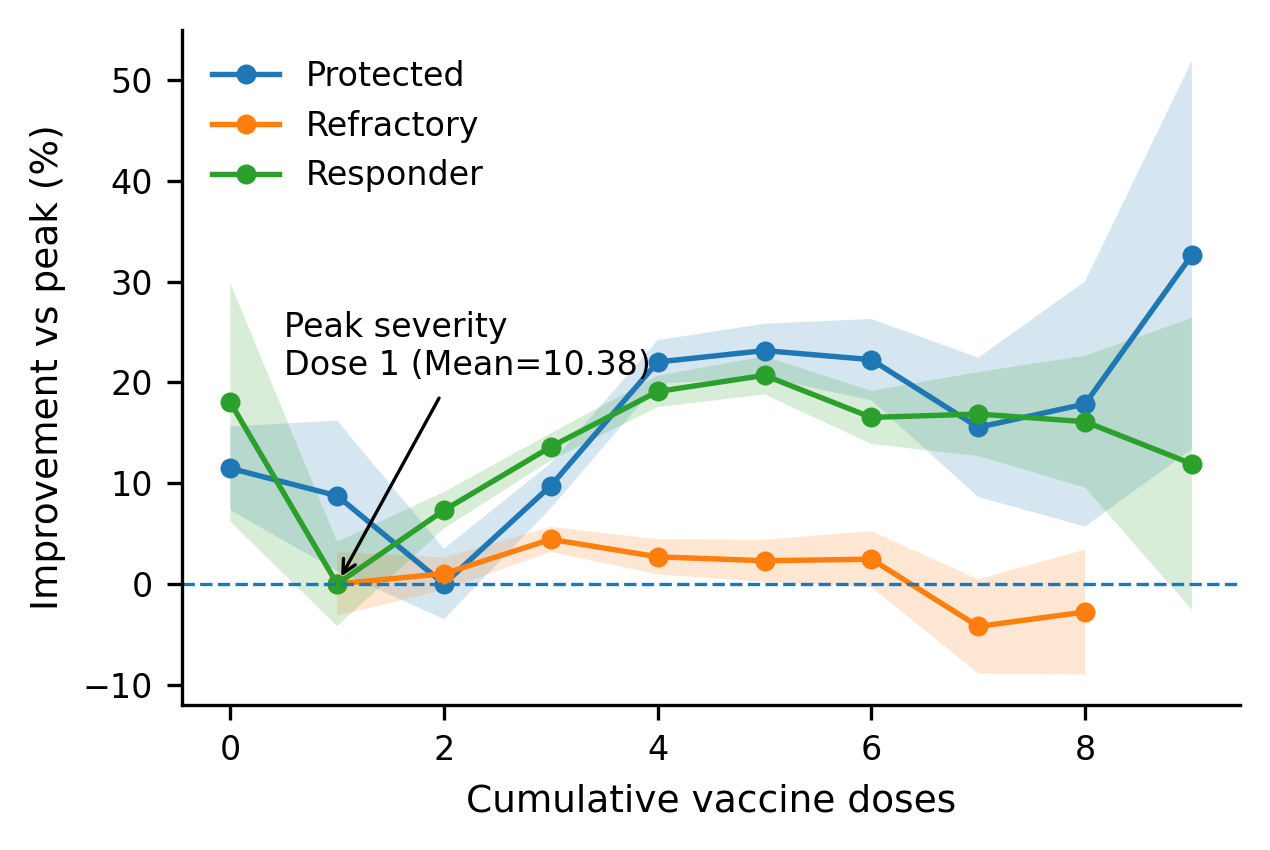

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# -------------------------
# Plot (Nature-ish minimalist)
# -------------------------
plt.rcParams.update({
    "font.family":"sans-serif",
    "font.sans-serif":["Helvetica","Arial","DejaVu Sans"],
    "pdf.fonttype":42,
    "axes.linewidth":0.8
})

fig, ax = plt.subplots(figsize=(4.2, 2.8), dpi=300)

for g, gdf in df_plot.groupby("group"):
    gdf = gdf.sort_values("dose")
    ax.plot(gdf["dose"], gdf["improve_pct"], marker="o", linewidth=1.3, markersize=3.8, label=g)
    ax.fill_between(gdf["dose"], gdf["low"], gdf["high"], alpha=0.18)

# 0% = cohort peak
ax.axhline(0, linestyle="--", linewidth=0.8)

# Annotate responder peak
rpeak = df2[(df2["group"]=="Responder") & (df2["dose"]==1)].iloc[0]
ax.annotate(
    f"Peak severity\nDose 1 (Mean={rpeak['peak_mean']:.2f})",
    xy=(1, 0), xytext=(0.5, 20),
    arrowprops=dict(arrowstyle="->", linewidth=0.8),
    fontsize=8, ha="left", va="bottom"
)

ax.set_xlabel("Cumulative vaccine doses", fontsize=9)
ax.set_ylabel("Improvement vs peak (%)", fontsize=9)
ax.tick_params(direction="out", length=3.5, width=0.8, labelsize=8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False, fontsize=8, loc="upper left")

fig.tight_layout(pad=0.6)
fig.savefig("DoseResponse_Improvement_AllGroups_95CI.pdf", bbox_inches="tight")
plt.show()

In [23]:
df = pasc_df.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.rename(columns={"name": "pasc_score"})   # rename for clarity
df = df.sort_values(["id", "date"])
protected_set  = set(protected_ids)
responder_set  = set(responder_ids)
refractory_set = set(refractory_ids)

def id_to_group(pid):
    if pid in protected_set:  return "Protected"
    if pid in responder_set:  return "Responder"
    if pid in refractory_set: return "Refractory"
    return np.nan

df["group_name"] = df["id"].map(id_to_group)
df = df.dropna(subset=["group_name"])
idx_peak = df.groupby("id")["pasc_score"].idxmax()
peak_df = (
    df.loc[idx_peak, ["id", "group_name", "date", "pasc_score"]]
      .rename(columns={"date":"peak_date", "pasc_score":"peak_pasc"})
      .reset_index(drop=True)
)
if "prior_vax_count" in df.columns:
    base_dose_df = (
        df.groupby("id", as_index=False)
          .first()[["id","prior_vax_count"]]
          .rename(columns={"prior_vax_count":"baseline_vax_doses"})
    )
else:
    base_dose_df = None
# pasc_df.head()
initial_df = (
    df.groupby("id", as_index=False)
      .first()[["id", "group_name", "date", "pasc_score"]]
      .rename(columns={"date":"initial_date", "pasc_score":"initial_pasc"})
)
df_individual = initial_df.merge(peak_df, on=["id","group_name"], how="inner")

if base_dose_df is not None:
    df_individual = df_individual.merge(base_dose_df, on="id", how="left")

# Optional: keep only the 3 cohorts, ordered labels
df_individual["group_name"] = pd.Categorical(
    df_individual["group_name"],
    categories=["Protected","Responder","Refractory"],
    ordered=True
)

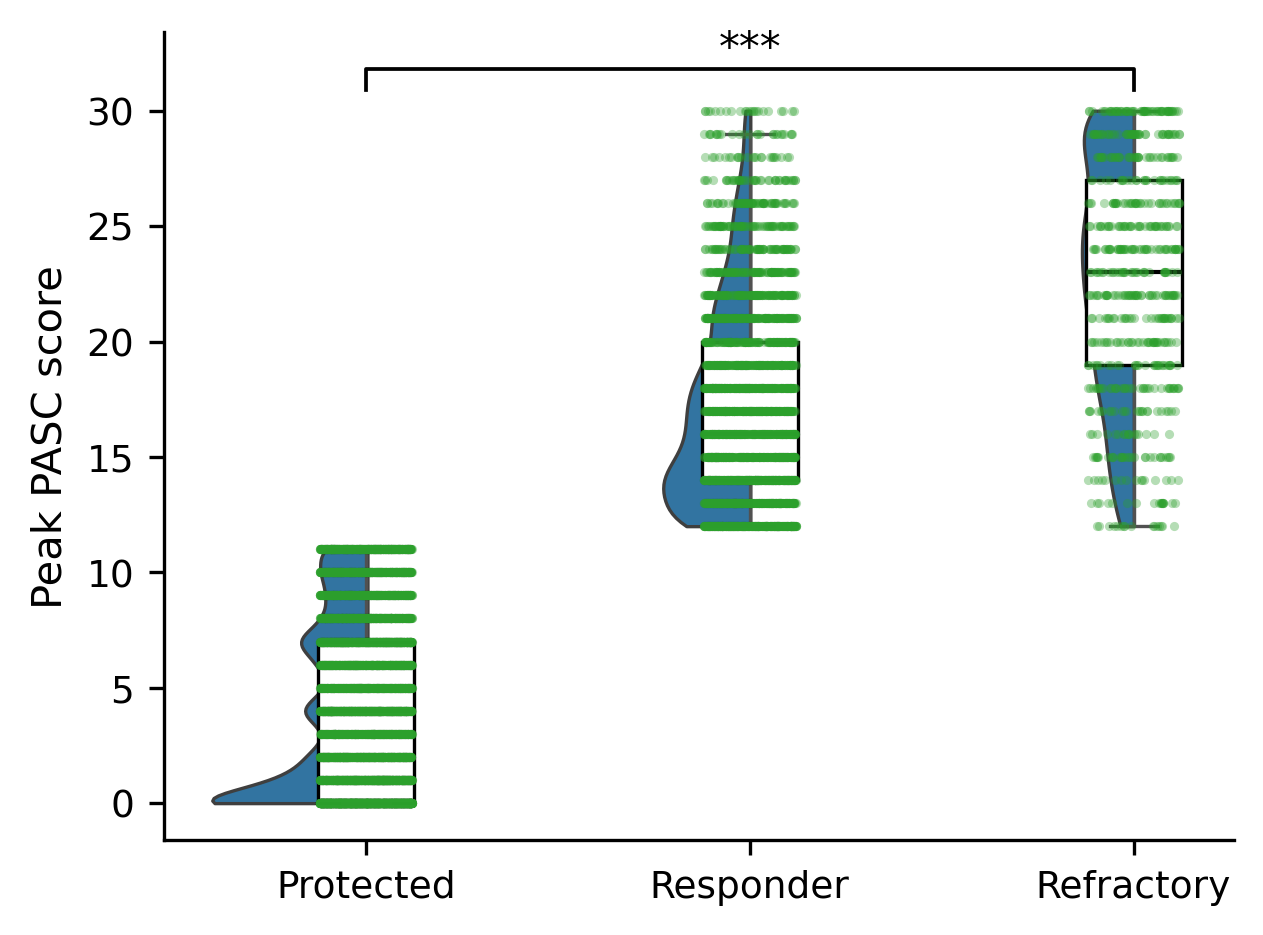

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# -------------------------
# Style (Nature-ish)
# -------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
    "pdf.fonttype": 42,
    "axes.linewidth": 0.8,
})

ORDER = ["Protected", "Responder", "Refractory"]

def make_half_violin(ax, side="left"):
    """
    Convert full violins drawn by seaborn.violinplot into half violins.
    side: "left" or "right" relative to the category centerline.
    """
    for c in ax.collections:
        if isinstance(c, PolyCollection):
            paths = c.get_paths()
            for p in paths:
                verts = p.vertices
                # violin is centered at x ~ category position; clip to one side
                x_center = np.mean(verts[:, 0])
                if side == "left":
                    verts[:, 0] = np.minimum(verts[:, 0], x_center)
                else:
                    verts[:, 0] = np.maximum(verts[:, 0], x_center)

def add_sig_bracket(ax, x1, x2, y, h, text="***", lw=0.9):
    """
    Add significance bracket between category indices x1 and x2.
    """
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c="black", clip_on=False)
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=10)

def raincloud(ax, df, y, x="group_name", order=ORDER,
              violin_side="left", jitter=0.12):
    """
    Raincloud = half violin + box + raw points.
    df must contain individual-level values in column y.
    """
    # Half violin (no inner)
    sns.violinplot(
        data=df, x=x, y=y, order=order,
        inner=None, cut=0, linewidth=0.8,
        ax=ax
    )
    make_half_violin(ax, side=violin_side)

    # Boxplot (thin, on top)
    sns.boxplot(
        data=df, x=x, y=y, order=order,
        width=0.25, showcaps=True, showfliers=False,
        boxprops={"facecolor":"white", "edgecolor":"black", "linewidth":0.8},
        whiskerprops={"linewidth":0.8},
        capprops={"linewidth":0.8},
        medianprops={"color":"black", "linewidth":1.0},
        ax=ax
    )

    # Raw points (cloud)
    sns.stripplot(
        data=df, x=x, y=y, order=order,
        size=2.2, jitter=jitter, alpha=0.35,
        edgecolor=None, linewidth=0,
        ax=ax
    )

    # Clean spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="out", length=3.5, width=0.8, labelsize=9)
    ax.set_xlabel("")
    return ax

# -------------------------
# Example usage
# -------------------------
# REQUIRED: df_individual must have individual rows, e.g.:
# df_individual columns:
#   group_name in {"Protected","Responder","Refractory"}
#   peak_pasc (per patient peak), initial_pasc (per patient), avg_vax_doses (per patient)
#
# df_individual = ...

fig, ax = plt.subplots(figsize=(4.2, 3.1), dpi=300)

# Choose which Table 3 continuous feature to plot:
# 1) Peak PASC Score
raincloud(ax, df_individual, y="peak_pasc")

ax.set_ylabel("Peak PASC score", fontsize=10)

# Significance bracket across all 3 groups (overall p < 0.001 from Table 3)
ymax = np.nanmax(df_individual["peak_pasc"])
add_sig_bracket(ax, x1=0, x2=2, y=ymax*1.03, h=ymax*0.03, text="***")

fig.tight_layout(pad=0.6)
fig.savefig("Table3_PeakPASC_Raincloud.pdf", bbox_inches="tight")
plt.show()


/tmp/ipykernel_106/764972151.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_106/764972151.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of

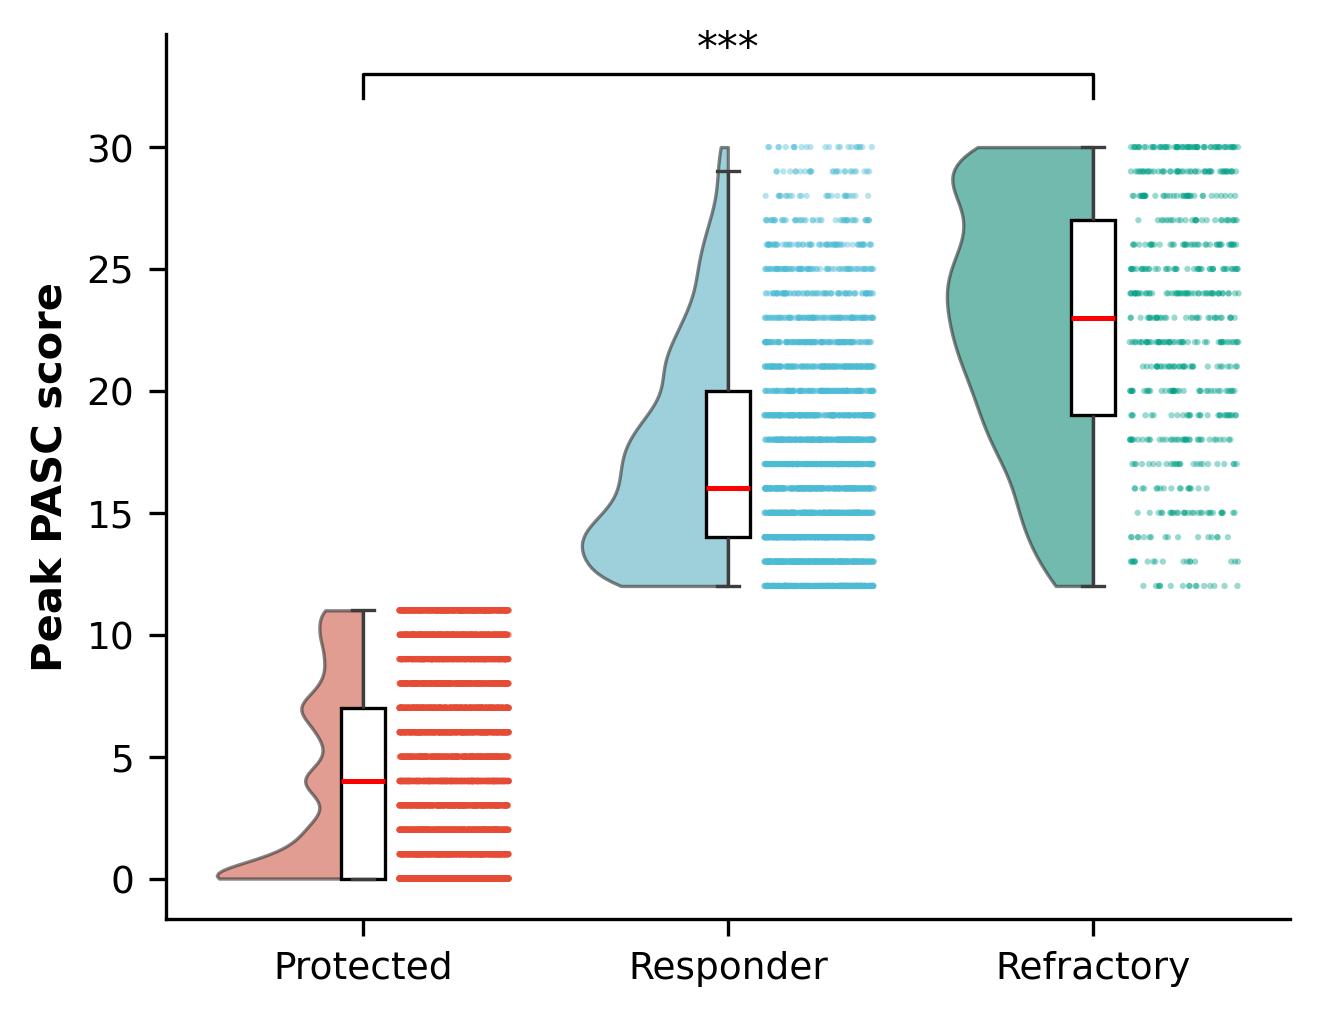

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

# -------------------------
# Style (Nature-Standard)
# -------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica"],
    "pdf.fonttype": 42,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8
})

ORDER = ["Protected", "Responder", "Refractory"]
COLORS = ['#E64B35FF', '#4DBBD5FF', '#00A087FF'] # Your NPG colors

def raincloud_nature(ax, df, y, x="group_name", order=ORDER, colors=COLORS):
    # 1. Violin Plot (Cloud) - Shifted to the left
    # We use 'half' logic by drawing and then clipping
    sns.violinplot(
        data=df, x=x, y=y, order=order, palette=colors,
        inner=None, cut=0, linewidth=0.8, ax=ax, alpha=0.6
    )
    
    for i, collection in enumerate(ax.collections):
        if isinstance(collection, PolyCollection):
            for path in collection.get_paths():
                verts = path.vertices
                center = i  # Category center
                # Clip to the left half
                verts[:, 0] = np.minimum(verts[:, 0], center)

    # 2. Stripplot (Rain) - Shifted to the right
    # We manually adjust the x-position of the points to avoid overlap
    sns.stripplot(
        data=df, x=x, y=y, order=order, palette=colors,
        size=1.5, alpha=0.4, jitter=0.15, marker='o', 
        linewidth=0, ax=ax
    )
    
    # Move the points to the right of the center
    for i, collection in enumerate(ax.collections):
        if not isinstance(collection, PolyCollection):
            # These are the PathCollections (dots)
            offsets = collection.get_offsets()
            offsets[:, 0] += 0.25 # Shift points to the right
            collection.set_offsets(offsets)

    # 3. Boxplot - Centered and thin
    sns.boxplot(
        data=df, x=x, y=y, order=order,
        width=0.12, showcaps=True, showfliers=False,
        boxprops={"facecolor": "white", "edgecolor": "black", "linewidth": 0.8, "zorder": 10},
        whiskerprops={"linewidth": 0.8, "zorder": 10},
        capprops={"linewidth": 0.8, "zorder": 10},
        medianprops={"color": "red", "linewidth": 1.2, "zorder": 11}, # Red median for visibility
        ax=ax
    )

    # Clean Spines
    sns.despine()
    ax.tick_params(direction="out", length=4, labelsize=9)
    ax.set_xlabel("")
    return ax

# -------------------------
# Execution
# -------------------------
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=300)

# Replace df_individual with your actual dataframe
raincloud_nature(ax, df_individual, y="peak_pasc")

ax.set_ylabel("Peak PASC score", fontsize=10, fontweight='bold')

# Significance bracket using the exact values from Table 3
# Protected vs Refractory (Overall p < 0.001)
ymax = df_individual["peak_pasc"].max()
y_pos = ymax + 2
ax.plot([0, 0, 2, 2], [y_pos, y_pos+1, y_pos+1, y_pos], lw=0.8, c="black")
ax.text(1, y_pos+1.2, "***", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("Nature_Raincloud_PeakPASC.pdf", format='pdf')
plt.show()

In [ ]:
# Create the figure
fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=300)

# 1. Plot the Raincloud for Initial Scores
# Ensure 'initial_pasc' is the column containing scores at enrollment/index 0
raincloud_nature(ax, df_individual, y="initial_pasc")

# 2. Nature-style Labeling
ax.set_ylabel("Initial PASC Score", fontsize=10, fontweight='bold')
plt.title("Baseline Severity at Enrollment", fontsize=11, pad=15)

# 3. Significance Bracket (ANOVA/Kruskal-Wallis p < 0.001 from Table 3)
# Set y_pos based on the distribution of initial scores
ymax = df_individual["initial_pasc"].max()
y_pos = ymax + 1
ax.plot([0, 0, 2, 2], [y_pos, y_pos + 0.5, y_pos + 0.5, y_pos], lw=0.8, c="black")
ax.text(1, y_pos + 0.6, "***", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("Nature_Raincloud_InitialPASC.pdf", format='pdf')
plt.show()

/tmp/ipykernel_106/764972151.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_106/764972151.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica
findfont: Generic family 'sans-serif' not found because none of

In [29]:
import pandas as pd
import numpy as np

# df_long must have: id, date, pasc_score, group_name
df_long = df_long.copy()
df_long["date"] = pd.to_datetime(df_long["date"])
df_long = df_long.sort_values(["id", "date"])

# Per-person summary
g = df_long.groupby("id", as_index=False)

df_initial = g.first()[["id", "group_name", "date", "pasc_score"]].rename(
    columns={"date": "initial_date", "pasc_score": "initial_pasc"}
)

df_last = g.last()[["id", "date", "pasc_score"]].rename(
    columns={"date": "last_date", "pasc_score": "last_pasc"}
)

df_min = g["pasc_score"].min().rename(columns={"pasc_score": "min_pasc"})
df_max = g["pasc_score"].max().rename(columns={"pasc_score": "peak_pasc"})  # matches Table 3 “Peak PASC”

df_nvis = g.size().rename(columns={"size": "n_visits"})

df_individual = (
    df_initial
    .merge(df_last, on="id", how="inner")
    .merge(df_min, on="id", how="left")
    .merge(df_max, on="id", how="left")
    .merge(df_nvis, on="id", how="left")
)

# Improvement direction based on LAST vs INITIAL
df_individual["delta_last_minus_initial"] = df_individual["last_pasc"] - df_individual["initial_pasc"]

df_individual["outcome"] = np.select(
    [
        df_individual["delta_last_minus_initial"] < 0,
        df_individual["delta_last_minus_initial"] > 0
    ],
    ["Improved (Last < Initial)", "Worsened (Last > Initial)"],
    default="Unchanged"
)

ORDER = ["Protected", "Responder", "Refractory"]
df_individual["group_name"] = pd.Categorical(df_individual["group_name"], categories=ORDER, ordered=True)


NameError: name 'df_long' is not defined